In [ ]:
!pip install transformers datasets peft accelerate torch tqdm evaluate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DRIVE_BASE = '/content/drive/MyDrive/ВКР/EmotionClassifier'
!mkdir -p "{DRIVE_BASE}/bert-head" "{DRIVE_BASE}/bert-full" "{DRIVE_BASE}/bert-lora"

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset
from sklearn.model_selection import train_test_split

df = pd.read_csv('gpt_oversampled_dusha_crowd.csv')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

train_val, test = train_test_split(df, test_size=0.1,
                                   stratify=df.final_emotion, random_state=42)
train, val   = train_test_split(train_val, test_size=0.1111,
                                 stratify=train_val.final_emotion, random_state=42)

def to_hf(ds):
    ds = Dataset.from_pandas(ds[['speaker_text','final_emotion']])
    ds = ds.rename_column('speaker_text','text')\
           .rename_column('final_emotion','label')
    ds = ds.class_encode_column('label')
    return ds

ds_train, ds_val, ds_test = map(to_hf, (train, val, test))
NUM_LABELS = ds_train.features['label'].num_classes

Casting to class labels:   0%|          | 0/179180 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/22395 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/22398 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoTokenizer, DataCollatorWithPadding

MODEL_NAME = "DeepPavlov/rubert-base-cased"
tokenizer   = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, max_length=128)

ds_train = ds_train.map(tokenize, batched=True)
ds_val   = ds_val.map(  tokenize, batched=True)
ds_test  = ds_test.map( tokenize, batched=True)

data_collator = DataCollatorWithPadding(tokenizer)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/179180 [00:00<?, ? examples/s]

Map:   0%|          | 0/22395 [00:00<?, ? examples/s]

Map:   0%|          | 0/22398 [00:00<?, ? examples/s]

In [ ]:
import numpy as np
from evaluate import load as load_metric

metric_acc = load_metric("accuracy")
metric_f1  = load_metric("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
      'accuracy': metric_acc.compute(predictions=preds,references=labels)['accuracy'],
      'f1_macro': metric_f1.compute(predictions=preds,references=labels, average='macro')['f1'],
    }


In [ ]:
from collections import Counter
import torch.nn as nn

counts = Counter(ds_train['label'])
weights = torch.tensor([1.0/counts[i] for i in range(NUM_LABELS)])
weights = weights / weights.sum() * NUM_LABELS
loss_fn = nn.CrossEntropyLoss(weight=weights.to('cuda'))


# HEAD-ONLY

In [ ]:
import torch
import torch.nn as nn
from collections import Counter
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        loss = loss_fn(outputs.logits, labels.to(outputs.logits.device))
        return (loss, outputs) if return_outputs else loss

model_head = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NUM_LABELS
).to(device)

args = TrainingArguments(
    output_dir=f"{DRIVE_BASE}/bert-head",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    report_to="none",
)

trainer_head = WeightedTrainer(
    model=model_head,
    args=args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer_head.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-12-607a0aed5b6a>:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer_head = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.402700,0.395603,0.853271,0.858701
2,0.369100,0.433821,0.831302,0.837365


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.402700,0.395603,0.853271,0.858701
2,0.369100,0.433821,0.831302,0.837365
3,0.320700,0.411509,0.852467,0.857516
4,0.255900,0.458699,0.841125,0.847615
5,0.202900,0.565435,0.833534,0.840730


TrainOutput(global_step=28000, training_loss=0.3205175598689488, metrics={'train_runtime': 4351.3693, 'train_samples_per_second': 205.889, 'train_steps_per_second': 6.435, 'total_flos': 7724849077310976.0, 'train_loss': 0.3205175598689488, 'epoch': 5.0})

# FULL FINE-TUNE

In [ ]:
for p in model_head.base_model.parameters():
    p.requires_grad = True

args_full = TrainingArguments(
    output_dir=f"{DRIVE_BASE}/bert-full",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    save_total_limit=1,
    gradient_accumulation_steps=2,
    logging_steps=100,
    report_to="none"
)

trainer_full = WeightedTrainer(
    model=model_head, 
    args=args_full,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer_full.train()
trainer_full.save_model(f"{DRIVE_BASE}/bert-full")


<ipython-input-13-f182642b1b6a>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer_full = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.364900,0.406401,0.852154,0.857149
2,0.349200,0.409025,0.844787,0.850780


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.364900,0.406401,0.852154,0.857149
2,0.251200,0.469238,0.841125,0.847399


In [ ]:
from peft import get_peft_model, LoraConfig, TaskType

lora_conf = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8, lora_alpha=32, lora_dropout=0.1
)
model_lora = get_peft_model(
    AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS),
    lora_conf
).to('cuda')

args_lora = TrainingArguments(
    output_dir=f"{DRIVE_BASE}/bert-lora",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    save_total_limit=1,
    logging_steps=100,
    report_to="none"
)

trainer_lora = WeightedTrainer(
    model=model_lora,
    args=args_lora,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer_lora.train()
trainer_lora.save_model(f"{DRIVE_BASE}/bert-lora")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-14-3bf4ad14133b>:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer_lora = WeightedTrainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.421300,0.410706,0.850413,0.855089
2,0.446400,0.399359,0.851842,0.856906


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.421300,0.410706,0.850413,0.855089
2,0.446400,0.399359,0.851842,0.856906
3,0.412300,0.391875,0.854744,0.859456
4,0.414100,0.388753,0.855548,0.860338
5,0.393100,0.387182,0.855280,0.860031


In [ ]:
NUM_LABELS = ds_train.features["label"].num_classes 


=== Head Evaluation ===


<ipython-input-21-693b3c519089>:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return Trainer(model=model, tokenizer=tokenizer)


Accuracy: 0.8269 — F1-macro: 0.8342


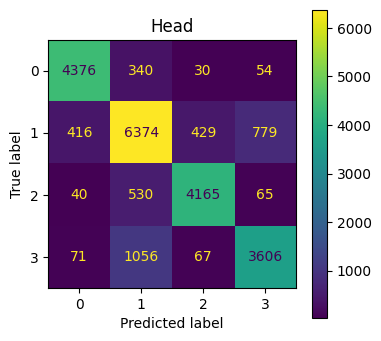


=== Full Evaluation ===


<ipython-input-21-693b3c519089>:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return Trainer(model=model, tokenizer=tokenizer)


Accuracy: 0.8459 — F1-macro: 0.8508


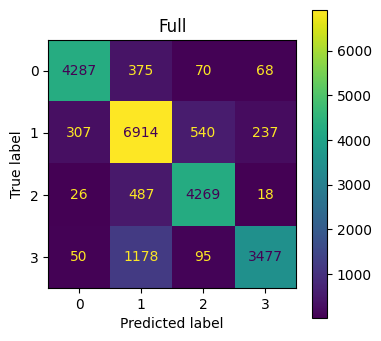


=== LoRA Evaluation ===


<ipython-input-21-693b3c519089>:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return Trainer(model=model, tokenizer=tokenizer)


Accuracy: 0.8503 — F1-macro: 0.8549


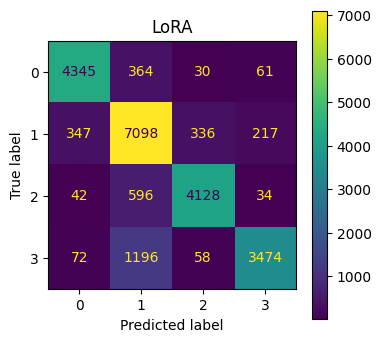

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer
)
from peft import PeftModel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

os.environ["WANDB_DISABLED"] = "true"

def find_latest_ckpt(dirpath):
    cks = [d for d in os.listdir(dirpath) if d.startswith("checkpoint-")]
    if not cks:
        return dirpath
    cks = sorted(cks, key=lambda x: int(x.split("-")[1]))
    return os.path.join(dirpath, cks[-1])

def load_trainer_checkpoint(path, hf_model_name="DeepPavlov/rubert-base-cased"):
    ckpt = find_latest_ckpt(path)

    try:
        model = AutoModelForSequenceClassification.from_pretrained(
            ckpt, local_files_only=True
        )
    except Exception:
        config = AutoConfig.from_pretrained(
            hf_model_name,
            num_labels=NUM_LABELS,
            local_files_only=False
        )
        base = AutoModelForSequenceClassification.from_pretrained(
            hf_model_name,
            config=config,
            local_files_only=False
        )
        model = PeftModel.from_pretrained(
            base, ckpt,
            local_files_only=True
        )
    model.to("cuda")
    return Trainer(model=model, tokenizer=tokenizer)

for name, path in [
    ("Head", f"{DRIVE_BASE}/bert-head"),
    ("Full", f"{DRIVE_BASE}/bert-full"),
    ("LoRA", f"{DRIVE_BASE}/bert-lora"),
]:
    print(f"\n=== {name} Evaluation ===")
    trainer = load_trainer_checkpoint(path)
    res     = trainer.predict(ds_test)
    preds   = np.argmax(res.predictions, axis=-1)
    labels  = ds_test["label"]

    acc = metric_acc.compute(predictions=preds, references=labels)["accuracy"]
    f1  = metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    print(f"Accuracy: {acc:.4f} — F1-macro: {f1:.4f}")

    cm   = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=trainer.model.config.id2label)
    plt.figure(figsize=(4,4))
    disp.plot(cmap="viridis", values_format="d", ax=plt.gca())
    plt.title(name)
    plt.show()


In [22]:
trainer_head.save_model("oversampling_bert-head")
trainer_full.save_model("oversampling_bert-full")
trainer_lora.save_model("oversampling_bert-lora")